In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# this data set contains the most relevant alarms 
data = pd.read_csv('./dataframes/clean_data.csv')
data_bck=data.copy()

# All events

## Alarms sets creation

In [3]:
data.head()

,Unnamed: 0.1,Unnamed: 0,level_0,DateTime,rounding,Nr per 10,date,unique_alarms_date,MsgNr,Ms,...,Year-Week,seconds_diff,dependence_bigger10min,dependence_5-10min,dependence_1-5min,dependence_1min,inverted,output,new_output,sequences
0,0,0,0,2022-01-03 05:49:49,2022-01-03 05:40:00,1,2022-01-03,140,50217,851,...,2022-01,NaN,1,0,0,1,NaN,0,0.0,0
1,1,1,1,2022-01-03 08:41:45,2022-01-03 08:40:00,10,2022-01-03,140,15042,571,...,2022-01,10316.0,1,0,0,1,1.0,0,0.0,0
2,2,2,2,2022-01-03 08:44:22,2022-01-03 08:40:00,10,2022-01-03,140,4074,129,...,2022-01,157.0,0,0,1,1,1.0,0,0.0,0
3,3,3,3,2022-01-03 08:46:40,2022-01-03 08:40:00,10,2022-01-03,140,15042,908,...,2022-01,138.0,0,0,1,1,1.0,0,0.0,0
4,4,4,4,2022-01-03 09:07:11,2022-01-03 09:00:00,6,2022-01-03,140,15042,731,...,2022-01,1231.0,1,0,0,1,1.0,0,0.0,0


In [4]:
transactions = data.groupby('sequences')['MsgNr'].apply(list).tolist()
transactions.pop(0)
transactions[166]

[11232, 11231, 11231, 11231, 11231, 11231, 11231, 11231, 11231, 11232]

In [5]:
len(transactions)

47597

In [6]:
data_bck = data.copy()

In [7]:
sum(len(i) for i in transactions)

313717

## Alarm Exploration

### Chattering Alarms

In [8]:
#total number of alarms in sets
alarms_in_transactions = sum([len(sublist) for sublist in transactions])
print('total number of alarms in sets:', alarms_in_transactions)

total number of alarms in sets: 313717


In [9]:
#removing chattering alarms
transactions_clean = [set(i) for i in transactions]

#count number of unique alarms per set
number_clean = sum([len(sublist) for sublist in transactions_clean])
print('total unique alarms in sets', number_clean)

total unique alarms in sets 109723


Text(0, 0.5, 'times')

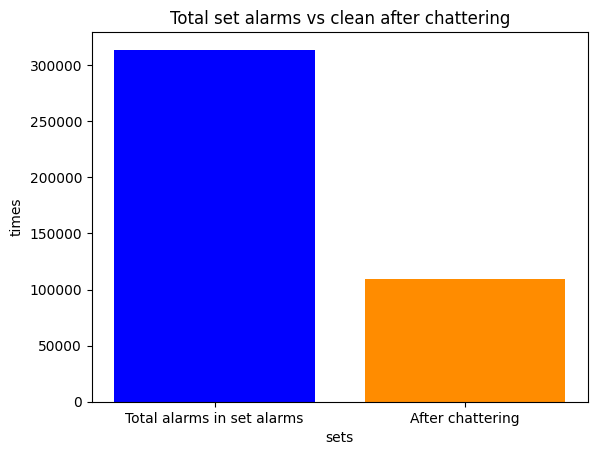

In [10]:
# plot the results
plt.bar(['Total alarms in set alarms', 'After chattering'], [alarms_in_transactions, number_clean], color = ["blue", "darkorange"])
plt.title('Total set alarms vs clean after chattering')
plt.xlabel("sets")
plt.ylabel("times")

## Apriori

In [17]:
from apyori import apriori

In [18]:
rules = apriori(transactions_clean, min_support=0.023, min_confidence=0.99, min_lift=0, min_length=2)

In [19]:
rule_list=[]

for rule in rules:
    if len(rule.items) > 1:
        sequence = ', '.join([str(item) for item in rule.items])
        support = rule.support
        confidence = rule.ordered_statistics[0].confidence
        lift = rule.ordered_statistics[0].lift
        rule_list.append((sequence, support, confidence, lift))
        print(f"Frequent sequence: {sequence}, Support: {rule.support}, Confidence: {rule.ordered_statistics[0].confidence}, Lift: {rule.ordered_statistics[0].lift}")

Frequent sequence: 11225, 11226, Support: 0.25104523394331574, Confidence: 0.9994981179422836, Lift: 3.4694509859757057
Frequent sequence: 11225, 11226, 7167, Support: 0.046473517238481414, Confidence: 1.0, Lift: 3.4711931155192532
Frequent sequence: 11225, 11226, 11231, Support: 0.05996176229594302, Confidence: 1.0, Lift: 3.4711931155192532
Frequent sequence: 11232, 11225, 11226, Support: 0.05521356388007648, Confidence: 1.0, Lift: 3.4711931155192532
Frequent sequence: 22017, 22045, 22021, Support: 0.02308969052671387, Confidence: 0.9954710144927537, Lift: 41.309009482834874
Frequent sequence: 11232, 11225, 11226, 11231, Support: 0.04077988108494233, Confidence: 1.0, Lift: 3.4711931155192532


In [20]:
len(rule_list)

6

In [21]:
class BayesTheorem:
    
    def __init__(self, transactions):
        self.transactions = transactions

    def calculate_bayes(self, item1, item2):
                
        total_count = len(self.transactions) #how many sets of alarm exist
        
        #removes blank spaces from the itemlist
        transactions = [[str(item).strip() for item in sublist] for sublist in self.transactions]

        item1_count_duplicated = sum([i.count(item1) for i in transactions]) #count duplicates item 1
        item2_count_duplicated = sum([i.count(item2) for i in transactions]) #count duplicates item 2

        item1_count = sum([1 for i in transactions if item1 in set(i)]) #counts non-repeated
        item2_count = sum([1 for i in transactions if item2 in set(i)]) #counts non-repeated

        pA = (item1_count/total_count) #Probability of A
        pB = (item2_count/total_count)  #Probability of B

        columnA = [row for row in transactions if item1 in row] #Number of sets containing item A
        item2_A = sum([1 for i in columnA if item2 in set(i)]) #sum itemB being in sets containing A
               
        pBA = (item2_A/(len(columnA))) #given A, probability of B existing

        bayes =  ((pA*pBA)/pB)

        pA_x = round(float(pA), 4) # Example variable
        pB_x = round(float(pB), 4)  # Convert to float
        pBA_x = round(float(pBA), 4)
        bayes_X = round(float(bayes), 4)

        print(f'{item1}, {item2} & {pA_x} & {pB_x} & {pBA_x} & {bayes_X} \\')
        return bayes

In [22]:
# bt = BayesTheorem2('sequences')

bt = BayesTheorem(transactions)

result = bt.calculate_bayes('22021', '22045')
result

22021, 22045 & 0.0241 & 0.0236 & 0.9616 & 0.9813 \


0.9813167259786476

## Filtering sets of lists


In [17]:
data = data_bck.copy()

In [18]:
transactions_dt = data.groupby('sequences').apply(lambda x: {'DateTime': x['DateTime'].tolist(), 'MsgNr': x['MsgNr'].tolist()}).tolist()
transactions_dt.pop(0)
transactions_dt[166]

{'DateTime': ['2022-01-05 12:57:01',
  '2022-01-05 12:58:00',
  '2022-01-05 12:58:31',
  '2022-01-05 12:58:49',
  '2022-01-05 12:59:09',
  '2022-01-05 13:00:05',
  '2022-01-05 13:00:46',
  '2022-01-05 13:01:17',
  '2022-01-05 13:01:42',
  '2022-01-05 13:02:18'],
 'MsgNr': [11232,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11231,
  11232]}

In [19]:
list_of_activation = [11225, 11231]

In [20]:
class getList:
    def transform(data, alarm):
        transactions_clean = [i for i in data if i['MsgNr'][0] == alarm]
        df = pd.DataFrame(transactions_clean)
        df = df.explode('DateTime')
        filename = f'C:/Users/manda/OneDrive - ROCKWOOL Group/Documents/Mthesis/alarms_data/{alarm}.csv'
        with open(filename, 'w') as file:
            df.to_csv(file, index=False)
        return df

In [21]:
for i in list_of_activation:
    datos = getList.transform(transactions_dt, i)

Text(0, 0.5, 'times')

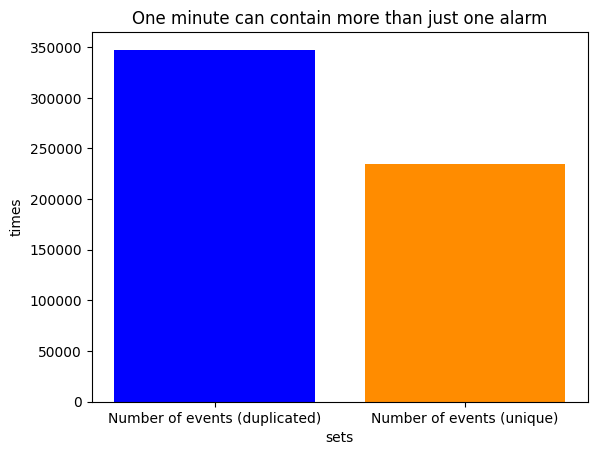

In [22]:
plt.bar(['Number of events (duplicated)', 'Number of events (unique)'], [data.shape[0], data.DateTime.nunique()], color = ["blue", "darkorange"])
plt.title('One minute can contain more than just one alarm')
plt.xlabel("sets")
plt.ylabel("times")

# Filtered alarms from all events

In [23]:
import pandas as pd
data = pd.read_csv('./dataframes/clean_data_reduction.csv')
data.head()

,Unnamed: 0,DateTime,MsgNr,Component,Plant,sequences
0,0,2022-01-03 09:17:48,9219,NaN,ACON/E-Welle,0
1,1,2022-01-03 09:28:03,49317,Kupolofen,BiMi-Lager,0
2,2,2022-01-03 09:36:43,16226,2-2.1F8,Schw.SpaltsÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂ...,0
3,3,2022-01-03 09:38:48,16226,2-2.1F8,Schw.SpaltsÃƒÂƒÃ‚ÂƒÃƒÂ‚Ã‚ÂƒÃƒÂƒÃ‚Â‚ÃƒÂ‚Ã‚ÂƒÃƒÂ...,1
4,4,2022-01-03 09:39:18,49317,Kupolofen,BiMi-Lager,1


In [24]:
data = data[['DateTime', 'MsgNr']]

In [25]:
pivot_df = data.pivot_table(index='DateTime', columns='MsgNr', aggfunc=len, fill_value=0)

In [26]:
pivot_df

MsgNr,2421,2445,4203,6280,6336,7167,9218,9219,9495,11225,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:17:48,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:28:03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-01-03 09:36:43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:38:48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:39:18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:53:15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:55:07,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:56:33,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
# pivot_df.to_csv('./dataframes./pivot_alarms.csv')

In [27]:
pivot_df.to_csv('./dataframes./pivot_alarms_cleaned_reduction.csv')

In [28]:
df = pivot_df.copy()

In [30]:
df

MsgNr,2421,2445,4203,6280,6336,7167,9218,9219,9495,11225,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:17:48,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:28:03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-01-03 09:36:43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:38:48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:39:18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:53:15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:55:07,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:56:33,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [31]:
# df = df.drop(columns=['seconds'])

In [32]:
pivot_df

MsgNr,2421,2445,4203,6280,6336,7167,9218,9219,9495,11225,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:17:48,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:28:03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-01-03 09:36:43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:38:48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-01-03 09:39:18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:53:15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:55:07,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-31 23:56:33,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:

fig, axs = plt.subplots(len(pivot_df.columns), 1, figsize=(20, 3*len(pivot_df.columns)))

for i, column in enumerate(pivot_df.columns):
    axs[i].plot(pivot_df[column])
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 